# Setup

In [1]:
from pathlib import Path
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from tensorflow.config.experimental import list_physical_devices

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-04-15 22:28:59.467854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 22:28:59.467881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 22:28:59.468751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 22:28:59.473491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 22:29:00.009853: W tensorflow/compiler/tf2

Num GPUs Available:  1


2024-04-15 22:29:00.615202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:29:00.629807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:29:00.629987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# TensorFlow Autoencoder

## Getting the data

In [2]:
def get_data(directory='../datasets/raw/renders_2d/images/', color=False):
    
    # count nr. of files to initialize numpy array
    _, _, files = next(os.walk(directory))
    file_count = len(files)

    if color:
        imgs = np.zeros(shape=(file_count, 256, 256, 3))
    else:
        imgs = np.zeros(shape=(file_count, 256, 256))
    
    # iterate over files in that directory
    files = Path(directory).glob('*')
    for idx, file in enumerate(files):
        if color:
            imgs[idx] = cv2.imread(str(file))[:, :, ::-1] # color
        else:
            imgs[idx] = cv2.imread(str(file), 0) # grayscale
    
    return imgs

In [3]:
imgs = get_data(color=True)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
print(imgs.shape)
print(imgs[0, :, :].shape)
print(imgs[0, 128, 128])

(819, 256, 256, 3)
(256, 256, 3)
[255. 255. 255.]


In [5]:
x_train, x_test = train_test_split(imgs, test_size=0.2)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

print(x_train.shape)
print(x_train[0, :, :].shape)
print(x_train[0, 128, 128, :])

print(np.count_nonzero(np.isnan(x_train)))

(655, 256, 256, 3)
(164, 256, 256, 3)
(655, 256, 256, 3)
(256, 256, 3)
[0.5647059  0.6117647  0.43137255]
0


## Defining the model

In [6]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
print(shape)
latent_dim = 640 # hyperparam
autoencoder = Autoencoder(latent_dim, shape)

(256, 256, 3)


2024-04-15 22:29:02.033099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:29:02.033364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:29:02.033553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Training the model
Train the model using x_train as both the input and the target. The encoder will learn to compress the dataset from 784 dimensions to the latent space, and the decoder will learn to reconstruct the original images.

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=100, # hyperparam
                shuffle=True,
                validation_data=(x_test, x_test))

2024-04-15 22:29:02.389095: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515112960 exceeds 10% of free system memory.
2024-04-15 22:29:02.640599: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515112960 exceeds 10% of free system memory.
2024-04-15 22:29:02.942099: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515112960 exceeds 10% of free system memory.
2024-04-15 22:29:03.076486: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515112960 exceeds 10% of free system memory.


Epoch 1/100


2024-04-15 22:29:03.742611: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 22:29:04.049506: I external/local_xla/xla/service/service.cc:168] XLA service 0x5fe848e1ca30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 22:29:04.049528: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-04-15 22:29:04.053673: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 22:29:04.065297: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1713212944.134848   46392 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 2s 49ms/step - loss: 0.1120 - val_loss: 0.0891
Epoch 2/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0789 - val_loss: 0.0742
Epoch 3/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0673 - val_loss: 0.0707
Epoch 4/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0606 - val_loss: 0.0664
Epoch 5/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0566 - val_loss: 0.0671
Epoch 6/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0526 - val_loss: 0.0618
Epoch 7/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0484 - val_loss: 0.0599
Epoch 8/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0455 - val_loss: 0.0582
Epoch 9/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0428 - val_loss: 0.0568
Epoch 10/100
21/21 [==============================] - 1s 34ms/step - loss: 0.0411 - val_loss: 0.0566
Epoch 11/10

In [9]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

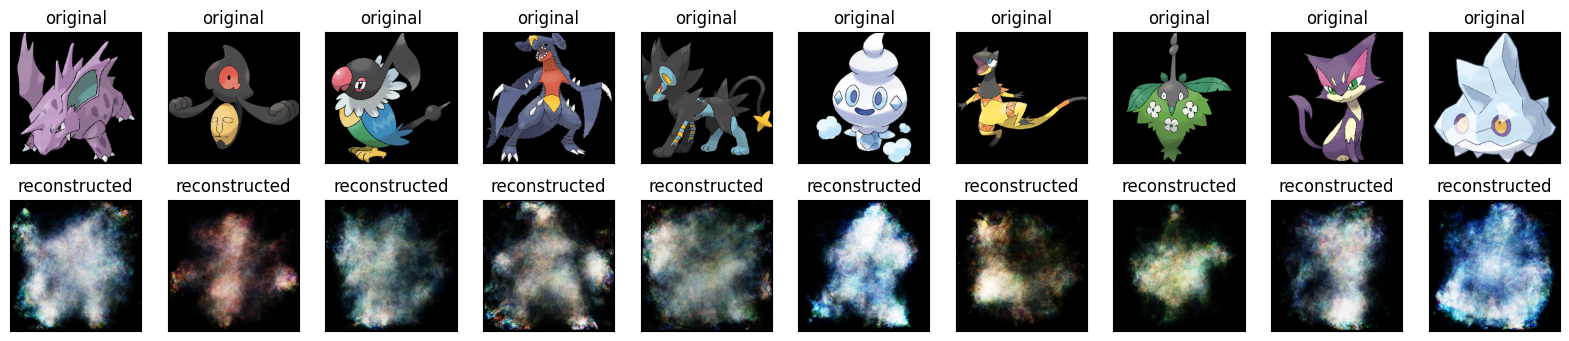

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()